**1. Import các thư viện cần thiết**

In [1]:
# 1. Các thư viện cần thiết
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_log_error as msle

**2. Đọc file dữ liệu và chia dataset theo tỉ lệ 8:2**

In [2]:
# Đọc file dữ liệu
df = pd.read_csv('D:\CTG.csv')

df = df[['Price','Low']]
df = df.dropna() # Drop missing values
df = df.reset_index(drop=True) # Reset the index
df1 = df
# Split the data into training, testing, and validation
train_size = int(0.8 * len(df))
test_size = int(0.2 * len(df))

train_data = df[:train_size]
test_data = df[train_size:train_size+test_size]


**Xem** **lại** **dataset**

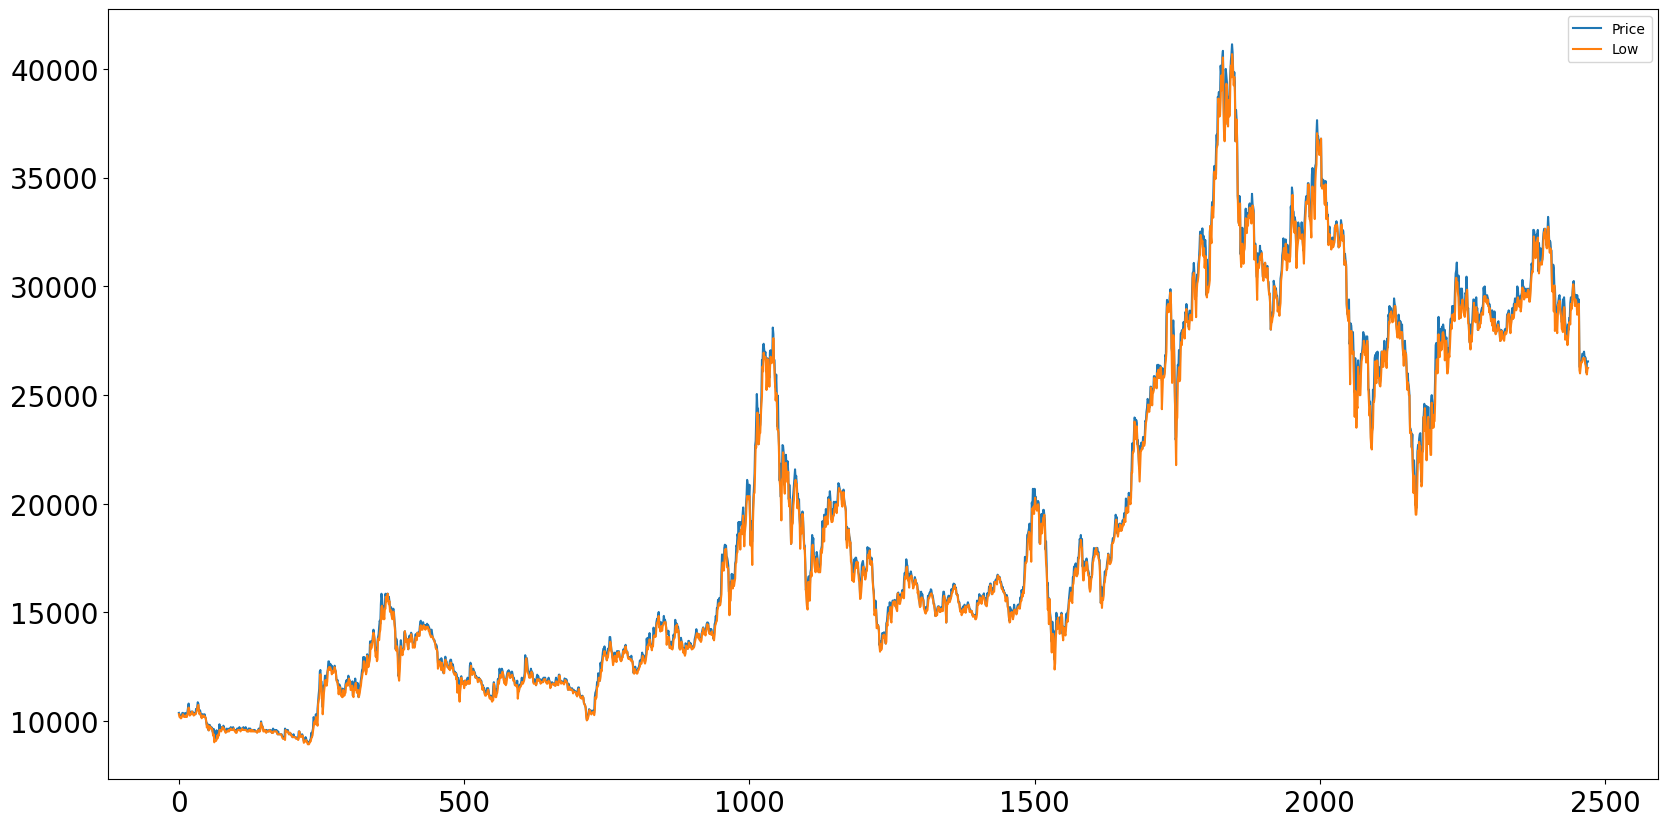

In [3]:
df.plot(figsize=(20, 10), fontsize=20)
plt.show()

***Tìm m thích hợp***

In [4]:
# Dùng adf để kiểm tra xem dataset có stationary hay chưa
from statsmodels.tsa.stattools import adfuller
adfuller(df['Price'])

(-1.4790235352046806,
 0.5438614038107454,
 1,
 2469,
 {'1%': -3.4330013210750745,
  '5%': -2.8627113331035243,
  '10%': -2.567393547066656},
 36992.4752760539)

In [5]:
# Vì dataset chưa stationary nên ta thực hiện diff()
df_diff = df1['Price'].diff().dropna()

In [6]:
# Tiếp tục dùng adf để kiểm tra xem p value có < 0.05 ko
adfuller(df_diff)

(-51.946172382469705,
 0.0,
 0,
 2469,
 {'1%': -3.4330013210750745,
  '5%': -2.8627113331035243,
  '10%': -2.567393547066656},
 36978.54167482712)

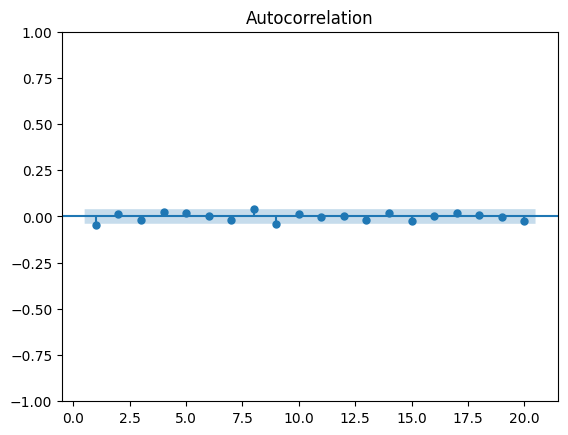

In [7]:
# Sau khi dataset đã stationary vẽ acf để tìm m
from statsmodels.graphics.tsaplots import plot_acf
plot_acf(df_diff, lags = 20 , zero = False)
plt.show()

**3. Dùng auto_arima để tìm model thích hợp**

In [8]:
df

,Price,Low
0,10379.9,10318.5
1,10318.5,10195.6
2,10257.0,10195.6
3,10195.6,10134.2
4,10195.6,10134.2
...,...,...
2466,26700.0,26350.0
2467,26050.0,26050.0
2468,26500.0,25950.0
2469,26550.0,26200.0


In [9]:
# Tạo y_train, x_train
x_train = np.array(train_data.index).reshape(-1, 1)
y_train = np.array(train_data['Price'])
# Dùng auto_arima để tìm thông số thích hợp
from pmdarima.arima import auto_arima
model = auto_arima(y_train, trace=True, error_action='ignore', suppress_warnings=True, seasonal = True, m =5)

Performing stepwise search to minimize aic
 ARIMA(2,1,2)(1,0,1)[5] intercept   : AIC=29486.489, Time=1.43 sec
 ARIMA(0,1,0)(0,0,0)[5] intercept   : AIC=29493.298, Time=0.02 sec
 ARIMA(1,1,0)(1,0,0)[5] intercept   : AIC=29494.900, Time=0.10 sec
 ARIMA(0,1,1)(0,0,1)[5] intercept   : AIC=29495.133, Time=0.09 sec
 ARIMA(0,1,0)(0,0,0)[5]             : AIC=29492.865, Time=0.01 sec
 ARIMA(2,1,2)(0,0,1)[5] intercept   : AIC=29484.605, Time=0.82 sec
 ARIMA(2,1,2)(0,0,0)[5] intercept   : AIC=29485.049, Time=0.49 sec
 ARIMA(2,1,2)(0,0,2)[5] intercept   : AIC=29486.510, Time=1.37 sec
 ARIMA(2,1,2)(1,0,0)[5] intercept   : AIC=29484.651, Time=0.70 sec
 ARIMA(2,1,2)(1,0,2)[5] intercept   : AIC=29488.441, Time=1.41 sec
 ARIMA(1,1,2)(0,0,1)[5] intercept   : AIC=29483.171, Time=0.59 sec
 ARIMA(1,1,2)(0,0,0)[5] intercept   : AIC=29483.536, Time=0.61 sec
 ARIMA(1,1,2)(1,0,1)[5] intercept   : AIC=29485.157, Time=0.81 sec
 ARIMA(1,1,2)(0,0,2)[5] intercept   : AIC=29485.078, Time=0.88 sec
 ARIMA(1,1,2)(1,0,0

**Dùng SARIMAX để train model**

In [10]:
from statsmodels.tsa.statespace.sarimax import SARIMAX
model1 = SARIMAX(y_train, exog = np.array(train_data['Price']), order=(1,1,1), seasonal_order=(0,0,1,5))
model_fit = model1.fit()

C:\Users\user\AppData\Roaming\Python\Python311\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


**4. Quá trình test**

In [11]:
x_test = np.array(test_data.index).reshape(-1, 1)
y_test = np.array(test_data['Price'])
exg = np.array(test_data['Low'])
y_pred_test = model_fit.predict(start=len(y_train), end=len(y_test)+len(y_train)-1, exog=exg)
y_pred_test

array([33900., 33800., 33900., 34200., 34700., 33850., 33100., 33050.,
       32750., 32250., 34150., 34600., 34300., 34200., 33750., 33100.,
       34800., 35350., 35600., 37050., 36700., 36700., 36300., 36050.,
       36350., 36100., 36800., 34600., 34500., 34550., 34650., 34550.,
       33800., 33750., 34700., 33100., 33700., 33150., 33150., 31900.,
       32050., 32400., 32100., 31950., 31700., 32100., 32050., 31800.,
       31850., 32000., 32200., 32800., 32550., 32800., 32850., 32550.,
       32100., 31800., 31900., 31850., 32100., 32450., 32850., 32350.,
       32100., 32350., 32050., 31000., 31200., 31150., 30900., 29200.,
       28750., 28550., 28400., 28900., 27350., 25500., 27500., 27950.,
       27750., 26900., 27000., 27000., 25150., 24000., 25200., 24850.,
       23500., 24500., 24400., 26300., 25800., 25850., 25000., 25000.,
       26000., 26550., 26700., 27000., 27000., 27500., 27300., 26850.,
       27200., 26500., 27300., 27500., 27100., 25250., 24700., 24050.,
      

**6. Quá trình tạo index predict 30 ngày tiếp theo**

In [12]:
# Dùng thuật toán LR để tìm giá trị Low cho 30 ngày tiếp theo
from sklearn.linear_model import LinearRegression

ln_model = LinearRegression()

ln_model.fit(np.array(train_data.index).reshape(-1,1), train_data['Low'])

last_index =  df.index[-1]
last_data = pd.RangeIndex(start=last_index, stop=last_index+30, step=1)

# Create an array of 30 consecutive integers starting from last_index
x_next_30_days = np.array(range(last_index+1, last_index+31)).reshape(-1, 1)

# Dự đoán giá trị low 30 ngày tiếp theo
low_next_30_days = ln_model.predict(x_next_30_days)

# Predict the closing prices for the next 30 days
y_next_30_days = model_fit.predict(start=len(x_train), end = len(x_train)+ len(x_next_30_days)-1, exog=low_next_30_days)
# Print the predicted closing prices for the next 30 days
print('Predicted closing prices for the next 30 days:')
print(y_next_30_days)

Predicted closing prices for the next 30 days:
[30918.76178903 30928.34162004 30937.92145104 30947.50128205
 30957.08111306 30966.66094407 30976.24077507 30985.82060608
 30995.40043709 31004.98026809 31014.5600991  31024.13993011
 31033.71976112 31043.29959212 31052.87942313 31062.45925414
 31072.03908514 31081.61891615 31091.19874716 31100.77857817
 31110.35840917 31119.93824018 31129.51807119 31139.09790219
 31148.6777332  31158.25756421 31167.83739522 31177.41722622
 31186.99705723 31196.57688824]


***7.Đánh giá độ chính xác thuật toán***

In [13]:
#MSLE
test_msle = msle(y_test, y_pred_test)
print('Testing MSLE:', test_msle)

#RMSE
test_rmse = np.sqrt(np.mean((y_pred_test - y_test)**2))
print('Testing RMSE:', test_rmse)

#MAPE
test_mape = np.mean(np.abs((y_test - y_pred_test) / y_test)) * 100
print('Testing MAPE:', test_mape)

#MAE
test_mae = np.mean(np.abs(y_pred_test - y_test))
print('Testing MAE:', test_mae)

Testing MSLE: 0.00043150642204820076
Testing RMSE: 559.6684241041918
Testing MAPE: 1.3230293428082744
Testing MAE: 373.27935222671937


**8. Vẽ biểu đồ**

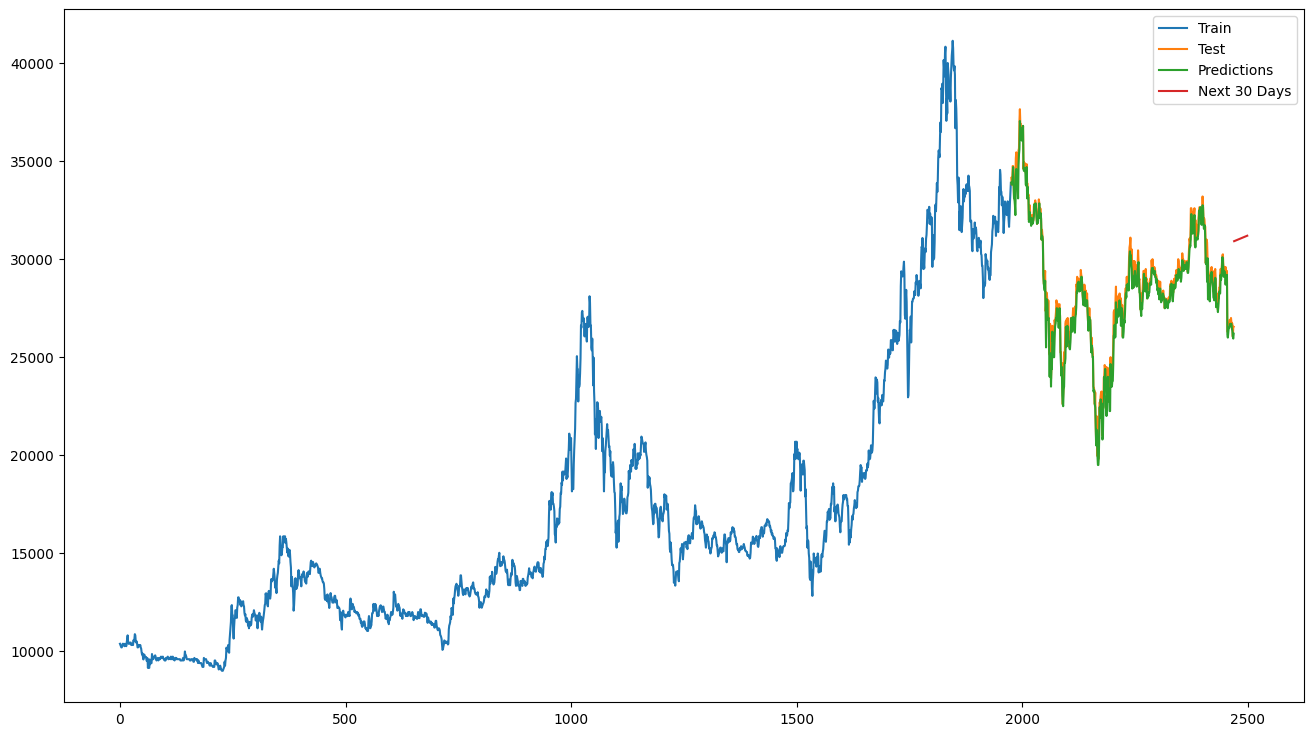

In [14]:
plt.figure(figsize=(16,9))
plt.plot(train_data.index, train_data['Price'])
plt.plot(test_data.index, test_data['Price'])
plt.plot(test_data.index, y_pred_test)
plt.plot(last_data,y_next_30_days)
plt.legend(['Train', 'Test', 'Predictions','Next 30 Days'])
plt.show()